This is a copy of my public kaggle kernel: https://www.kaggle.com/joatom/bigquery-geotab-bqml.

This solution led to the **1st Place** in the category *BigQuery ML Models built in SQL*.
# Introduction
This kernel includes all features and models that led to my final submission to the [BigQuery-GeoTab Competition](https://www.kaggle.com/c/bigquery-geotab-intersection-congestion).

My personal objective of the competition is to tryout BigQuery (BQ) including the basic ML features. Therefore the kernel relies as much as possible on BQ. All features are generated in BQ with varying SQL-techniques. The prediction model is also build in BQ. 

Since the ML features in BQ are currently limited to Lineare Regression, KMeans and Logistic Regression there is a subcompetition within the competition, that ranks top BQML submissions separatly. (There is also a second subcompetition for using TensorFlow with BigQuery.) This kernel aims towards the BQML subcompetition. 

The kernel uses all the provided ML algorithms:
- KMeans for Geo-Spatial Clustering
- Logistic Regression for Adversarial Validation
- Linear Regression for Prediction Model


## Summary
Features:
- intersectionid + city (*i_id*)
- city, hour, weekend, month
- path, entry_street_name, exit_street_name
- 20 clusters of intersections per city
- Distance to the 5 nearest cluster center
- 8 directions of turn (left, right, centered, uturn, centered-left, ...)
    - Directions, entry- and exit-heading are not embedded directly. Instead they are translated into degrees (e.g. centered = 90deg). 
    - Afterwards the degree features are split additionaly into two features sin(feature_x_deg) and cos(feature_x_deg).
    - Besides the direction of the turn, sin and cos feature are added for entry heading and exit heading 
- number of intersections per cluster
- number of observations per city and hour
- zipcode
- population of zipcode
- population of zipcode per intersection
- intersections per zipcode
- flag, if entry and exit are the same_street
- intersection observation frequency
- approching street length
- approching street length fallback flag, if approching street length was derived from a more general approach due of missing data

Features that didn't improve the model:
- daytime, season (removed from model, since not improving)
- road_type_entry, road_type_exit (removed from model, since not improving)

Train-Valid-Split:
- out of adversarial validation (drop 25 % of not test like data from train) (used by detailed model)
- split by id range (used by general model)

Train-Valid-Split that didn't improved the model:
- remove outliers (target > Q99) from train (removed from model, since not improving)

Model:
- Linear Regression
    - Detailed Model for known path and intersections in train and test
    - General Model for unknown path and intersections

## External data
The kernel uses zipcodes and population data from the public *bigquery-public-data*-set:
- bigquery-public-data.utility_us.zipcode_area
- bigquery-public-data.census_bureau_usa.population_by_zip_2010

The dataset can be included in the bigquery console (*add ressources*). I shared a preparation of the data (including references to intersections and a csv file for python users) [here](https://www.kaggle.com/joatom/bqml-population-of-zip-code-per-intersection).

## Credits
Some of the ideas are inspired by the following kernels. Please visit them and give them upvotes if you like them.
- This kernel is a forked from [BigQuery Machine Learning Tutorial](https://www.kaggle.com/rtatman/bigquery-machine-learning-tutorial).
- The direction features are like the Flow feature in https://www.kaggle.com/jpmiller/intersection-level-eda
- Intersection encoding in https://www.kaggle.com/danofer/baseline-feature-engineering-geotab-69-5-lb
- Adversarial Validation: https://www.kaggle.com/tunguz/adversarial-geotab
- Road encoding: https://www.kaggle.com/bgmello/how-one-percentile-affect-the-others)
- Same_Street feature: https://www.kaggle.com/ragnar123/feature-engineering-and-forward-feature-selection
- Remove Path and Intersection for general model: https://www.kaggle.com/gaborfodor/4-xgboost-general
- Approching Street Lengt inspired by EntryLength: https://www.kaggle.com/dan3dewey/bbq-intersection-congestion

In [1]:
# Replace 'kaggle-competitions-project' with YOUR OWN project id here --  
PROJECT_ID = 'kaggle-bq-geotag' #
#PROJECT_ID='kaggle-competitions-project'

from google.cloud import bigquery
client = bigquery.Client(project=PROJECT_ID, location="US")
dataset = client.create_dataset('bqml_example', exists_ok=True)

from google.cloud.bigquery import magics
from kaggle.gcp import KaggleKernelCredentials
magics.context.credentials = KaggleKernelCredentials()
magics.context.project = PROJECT_ID

import seaborn as sns
import matplotlib.pyplot as plt

# create a reference to our table
table = client.get_table("kaggle-competition-datasets.geotab_intersection_congestion.train")

# look at five rows from our dataset
client.list_rows(table, max_results=5).to_dataframe()

,RowId,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,...,TimeFromFirstStop_p40,TimeFromFirstStop_p50,TimeFromFirstStop_p60,TimeFromFirstStop_p80,DistanceToFirstStop_p20,DistanceToFirstStop_p40,DistanceToFirstStop_p50,DistanceToFirstStop_p60,DistanceToFirstStop_p80,City
0,2079854,33,42.34636,-71.09095,Fenway,Fenway,N,N,8,False,...,31,40,44,59,0.0,25.5,32.3,51.8,68.9,Boston
1,2079857,33,42.34636,-71.09095,Fenway,Fenway,N,N,13,False,...,0,10,17,29,0.0,0.0,9.9,21.8,40.4,Boston
2,2079872,33,42.34636,-71.09095,Fenway,Fenway,N,N,15,False,...,22,33,38,60,0.0,43.2,47.3,51.1,65.7,Boston
3,2079893,33,42.34636,-71.09095,Fenway,Fenway,N,N,12,False,...,0,14,18,31,0.0,0.0,15.6,22.5,44.4,Boston
4,2079896,33,42.34636,-71.09095,Fenway,Fenway,N,N,16,False,...,0,23,34,65,0.0,0.0,26.4,52.9,68.9,Boston


In [2]:
%load_ext google.cloud.bigquery

In [3]:
## Example to estimate quota usage

# https://stackoverflow.com/questions/47172150/google-cloud-bigquery-python-how-to-get-the-bytes-processed-by-query

sql = """
    SELECT t.city AS city
      FROM `kaggle-competition-datasets.geotab_intersection_congestion.train` t
      LIMIT 20"""

job_config = bigquery.QueryJobConfig()
job_config.dry_run = True

query_job = client.query(sql, job_config)

print ("This query will process: {0:.2f} MB".format(
    query_job.total_bytes_processed/1024/1024))


query_job = client.query(sql)
query_job.result()
print ("Total bytes processed (first execution): {0:.2f} MB".format(
    query_job.total_bytes_processed/1024/1024))


query_job = client.query(sql)
query_job.result()
print ("Total bytes processed (cached): {0:.2f} MB".format(
    query_job.total_bytes_processed/1024/1024))

This query will process: 9.04 MB
Total bytes processed (first execution): 0.00 MB
Total bytes processed (cached): 0.00 MB


In [4]:
def run_sql(sql, dry=False):
    if dry:
        job_config = bigquery.QueryJobConfig()
        job_config.dry_run = dry
        query_job = client.query(sql, job_config)
        print ("This query will process: {0:.2f} MB".format(query_job.total_bytes_processed/1024/1024))
    else: 
        query_job = client.query(sql)
        query_job.result()
        print ("Total bytes processed (cached): {0:.2f} MB".format(query_job.total_bytes_processed/1024/1024))
        

# Some basic variables
To reduce consumption of BQ quota the tables and models are only rebuild if necessary. To rebuild the entire project set **model_changed = True**. Be aware your google account might get charged. 

If you run on the free sandbox environment you don't have enough quota to run the entire kernel at once. You can then precede the kernel a few days after when your quota has been refreshed. In this case make sure to set the model_changed flag to **False** for the parts you already have built.

In [5]:
# for documentation set model_changed here globaly, for development set later in the appropriate cells
model_changed = False

There will by 12 Models. One for each percentile (20, 50, 80) per category (TotalTimeStopped, DistanceToFirstStop) per model typ (general or detailed).

In [6]:
mod_names= ['TotalTimeStopped_p20','TotalTimeStopped_p50','TotalTimeStopped_p80',
            'DistanceToFirstStop_p20','DistanceToFirstStop_p50','DistanceToFirstStop_p80']

# general model will look like [x+'_general' for x in mod_names]


Distinct cities

In [7]:
%%bigquery city_df --verbose
SELECT t.city
  FROM `kaggle-competition-datasets.geotab_intersection_congestion.test` t
UNION DISTINCT
SELECT t.city
  FROM `kaggle-competition-datasets.geotab_intersection_congestion.train` t


Executing query with job ID: ea53ba03-3f34-4cf1-b9b4-70eb88b84ef3
Query executing: 0.74s
Query complete after 1.04s


In [8]:
cities = list(city_df['city'])
cities

['Boston', 'Philadelphia', 'Atlanta', 'Chicago']

# Cluster Intersections per City
Build 20 geo spatial clusters of intersections per city:

In [9]:
#model_changed = False

if model_changed:
    for c in cities:
        sql="""DROP MODEL `bqml_example.model_cluster_"""+c+"""`"""
        client.query(sql)

        print('Dropped',c)
    
    
for c in cities:
    sql="""CREATE MODEL IF NOT EXISTS `bqml_example.model_cluster_"""+c+"""`
    OPTIONS(model_type='kmeans',
            NUM_CLUSTERS = 20) AS
    SELECT
        latitude,
        longitude
    FROM
      `kaggle-competition-datasets.geotab_intersection_congestion.train` t
    WHERE city = '"""+c+"""'
    UNION DISTINCT
    SELECT
        latitude,
        longitude
    FROM
      `kaggle-competition-datasets.geotab_intersection_congestion.test` t
    WHERE city = '"""+c+"""'"""

    client.query(sql).result()

    print('Done with',c)

Done with Boston
Done with Philadelphia
Done with Atlanta
Done with Chicago


A basic analysis of the clusters can be found in an earlier kernel [here](https://www.kaggle.com/joatom/bqml-incl-intersection-clusters).

## Match closest clusters to intersection
Now match the five closest cluster center to an intersection. Add distance from intersection to the five cluster center. Count number of intersection of the five surrouding clusters.

Safe this for further usage in the *CITY_CLUSTER* table.

In [10]:
sql=""

for c in cities:
    sql+= """
        SELECT
          city,
          intersectionid,
          CONCAT(city,"_", CAST(MAX(CASE WHEN rk = 1 THEN centroid_id END) AS string)) city_cluster_1,
          CONCAT(city,"_", CAST(MAX(CASE WHEN rk = 2 THEN centroid_id END) AS string)) city_cluster_2,
          CONCAT(city,"_", CAST(MAX(CASE WHEN rk = 3 THEN centroid_id END) AS string)) city_cluster_3,
          CONCAT(city,"_", CAST(MAX(CASE WHEN rk = 4 THEN centroid_id END) AS string)) city_cluster_4,
          CONCAT(city,"_", CAST(MAX(CASE WHEN rk = 5 THEN centroid_id END) AS string)) city_cluster_5,
          MAX(CASE WHEN rk = 1 THEN distance END) dist_to_cluster_center_1,
          MAX(CASE WHEN rk = 2 THEN distance END) dist_to_cluster_center_2,
          MAX(CASE WHEN rk = 3 THEN distance END) dist_to_cluster_center_3,
          MAX(CASE WHEN rk = 4 THEN distance END) dist_to_cluster_center_4,
          MAX(CASE WHEN rk = 5 THEN distance END) dist_to_cluster_center_5,
          COUNT(DISTINCT CONCAT(city, CAST(intersectionid AS string))) OVER(PARTITION BY CONCAT(city,"_", CAST(MAX(CASE WHEN rk = 1 THEN centroid_id END) AS string))) intersections_per_cluster_1,
          COUNT(DISTINCT CONCAT(city, CAST(intersectionid AS string))) OVER(PARTITION BY CONCAT(city,"_", CAST(MAX(CASE WHEN rk = 2 THEN centroid_id END) AS string))) intersections_per_cluster_2,
          COUNT(DISTINCT CONCAT(city, CAST(intersectionid AS string))) OVER(PARTITION BY CONCAT(city,"_", CAST(MAX(CASE WHEN rk = 3 THEN centroid_id END) AS string))) intersections_per_cluster_3,
          COUNT(DISTINCT CONCAT(city, CAST(intersectionid AS string))) OVER(PARTITION BY CONCAT(city,"_", CAST(MAX(CASE WHEN rk = 4 THEN centroid_id END) AS string))) intersections_per_cluster_4,
          COUNT(DISTINCT CONCAT(city, CAST(intersectionid AS string))) OVER(PARTITION BY CONCAT(city,"_", CAST(MAX(CASE WHEN rk = 5 THEN centroid_id END) AS string))) intersections_per_cluster_5
        FROM (
          SELECT
            b.*,
            RANK()OVER(PARTITION BY intersectionid ORDER BY b.distance) rk,
            a.* EXCEPT(centroid_id,
              NEAREST_CENTROIDS_DISTANCE)
          FROM
            ML.PREDICT(MODEL `bqml_example.model_cluster_"""+c+"""`,
              (
              SELECT
                longitude,
                latitude,
                intersectionid,
                city
              FROM
                `kaggle-competition-datasets.geotab_intersection_congestion.train`
              WHERE city = '"""+c+"""'
              UNION DISTINCT
              SELECT
                longitude,
                latitude,
                intersectionid,
                city
              FROM
                `kaggle-competition-datasets.geotab_intersection_congestion.test`
              WHERE city = '"""+c+"""'))a
          CROSS JOIN
            UNNEST(NEAREST_CENTROIDS_DISTANCE)b)
        GROUP BY
          city,
          intersectionid
          
        UNION ALL"""
    
sql = sql[:-len("UNION ALL")]


#model_changed = False

if model_changed:
    sql="DROP TABLE IF EXISTS `bqml_example.city_cluster`"
    job_result=client.query(sql).result()

sql = "CREATE TABLE IF NOT EXISTS `bqml_example.city_cluster` as " + sql

job_result=client.query(sql).result()
print('Table CITY_CLUSTER created.')

Table CITY_CLUSTER created.


## Train and Test data with one cluster
The following is a former version of the intersection clustering which combines train and test data with one cluster (the cluster where the intersection is located in). The query results are safed in the tables *CITY_CLUSTER_TRAIN* and *CITY_CLUSTER_TEST* which are used later on for adversarial validation. (Note: The two tables could probably be replaced by *CITY_CLUSTER* after a few changes to the adversarial validation model).

In [11]:
def feature_sql(model_name, rowid_split, incl_rowid, tab): 
    
    if incl_rowid:
        rowid = "t.RowId,"
    else:
        rowid = ""
    
    if tab == 'test':
        label = ""
    elif model_name == 'ALL':
        label = """t.TotalTimeStopped_p20,
                t.TotalTimeStopped_p50,
                t.TotalTimeStopped_p80,
                t.DistanceToFirstStop_p20,
                t.DistanceToFirstStop_p50,
                t.DistanceToFirstStop_p80,"""
    else:
        label = """t."""+model_name+""" as label,"""
    
    sql = ""
    
    for c in cities:
        features = """SELECT """+label+"""
                             """+rowid+"""
                             t.city,
                             t.EntryHeading,
                             t.ExitHeading,
                             t.Hour,
                             t.Weekend,
                             t.Month,
                             t.Latitude,
                             t.Longitude,
                             case 
                                 when t.entryheading = t.exitheading THEN
                                  "C"
                                 when ("N" in (t.entryheading, t.exitheading) and "S" in (t.entryheading, t.exitheading)) 
                                      OR 
                                      ("E" in (t.entryheading, t.exitheading) and "W" in (t.entryheading, t.exitheading)) 
                                      OR 
                                      ("NE" in (t.entryheading, t.exitheading) and "SW" in (t.entryheading, t.exitheading))  
                                      OR 
                                      ("SE" in (t.entryheading, t.exitheading) and "NW" in (t.entryheading, t.exitheading)) 
                                 THEN
                                  "U" 
                                 when (t.entryheading="N" and t.exitheading = "W") 
                                      OR(t.entryheading="NW" and t.exitheading = "SW") 
                                      OR(t.entryheading="W" and t.exitheading = "S") 
                                      OR(t.entryheading="SW" and t.exitheading = "SE") 
                                      OR(t.entryheading="S" and t.exitheading = "E") 
                                      OR(t.entryheading="SE" and t.exitheading = "NE") 
                                      OR(t.entryheading="E" and t.exitheading = "N") 
                                      OR(t.entryheading="NE" and t.exitheading = "NW") 
                                 THEN
                                  "L" 
                                 when (t.entryheading="N" and t.exitheading = "E") 
                                      OR(t.entryheading="NW" and t.exitheading = "NE") 
                                      OR(t.entryheading="W" and t.exitheading = "N") 
                                      OR(t.entryheading="SW" and t.exitheading = "NW") 
                                      OR(t.entryheading="S" and t.exitheading = "W") 
                                      OR(t.entryheading="SE" and t.exitheading = "SW") 
                                      OR(t.entryheading="E" and t.exitheading = "S") 
                                      OR(t.entryheading="NE" and t.exitheading = "SE") 
                                 THEN
                                  "R" 
                                 when (t.entryheading="N" and t.exitheading = "NW") 
                                      OR(t.entryheading="NW" and t.exitheading = "W") 
                                      OR(t.entryheading="W" and t.exitheading = "SW") 
                                      OR(t.entryheading="SW" and t.exitheading = "S") 
                                      OR(t.entryheading="S" and t.exitheading = "SE") 
                                      OR(t.entryheading="SE" and t.exitheading = "E") 
                                      OR(t.entryheading="E" and t.exitheading = "NE") 
                                      OR(t.entryheading="NE" and t.exitheading = "N") 
                                 THEN
                                  "CL" 
                                 when (t.entryheading="N" and t.exitheading = "NE") 
                                      OR(t.entryheading="NW" and t.exitheading = "N") 
                                      OR(t.entryheading="W" and t.exitheading = "NW") 
                                      OR(t.entryheading="SW" and t.exitheading = "W") 
                                      OR(t.entryheading="S" and t.exitheading = "SW") 
                                      OR(t.entryheading="SE" and t.exitheading = "S") 
                                      OR(t.entryheading="E" and t.exitheading = "SE") 
                                      OR(t.entryheading="NE" and t.exitheading = "E") 
                                 THEN
                                  "CR" 
                                 when (t.entryheading="N" and t.exitheading = "SW") 
                                      OR(t.entryheading="NW" and t.exitheading = "S") 
                                      OR(t.entryheading="W" and t.exitheading = "SE") 
                                      OR(t.entryheading="SW" and t.exitheading = "E") 
                                      OR(t.entryheading="S" and t.exitheading = "NE") 
                                      OR(t.entryheading="SE" and t.exitheading = "N") 
                                      OR(t.entryheading="E" and t.exitheading = "NW") 
                                      OR(t.entryheading="NE" and t.exitheading = "W") 
                                 THEN
                                  "UL" 
                                 when (t.entryheading="N" and t.exitheading = "SE") 
                                      OR(t.entryheading="NW" and t.exitheading = "E") 
                                      OR(t.entryheading="W" and t.exitheading = "NE") 
                                      OR(t.entryheading="SW" and t.exitheading = "N") 
                                      OR(t.entryheading="S" and t.exitheading = "NW") 
                                      OR(t.entryheading="SE" and t.exitheading = "W") 
                                      OR(t.entryheading="E" and t.exitheading = "SW") 
                                      OR(t.entryheading="NE" and t.exitheading = "S") 
                                 THEN
                                  "UR" 
                               else null end direction
                       FROM `kaggle-competition-datasets.geotab_intersection_congestion."""+tab+"""` t
                      WHERE city = '"""+c+"""' 
                       AND rowid """+rowid_split
                            
        sql += """
               SELECT (SELECT MIN(d.DISTANCE) FROM UNNEST(NEAREST_CENTROIDS_DISTANCE) d) AS dist_to_cluster_center, 
                      CONCAT(m.city,"_",CAST(m.CENTROID_ID AS STRING)) AS city_cluster,
                      m.* EXCEPT (nearest_centroids_distance, CENTROID_ID,Latitude,Longitude) 
                 FROM ML.PREDICT(MODEL `bqml_example.model_cluster_"""+c+"""`, 
                              ("""+features+""")) m
               UNION ALL"""
        
        
    return sql[:-len("UNION ALL")]

In [12]:
#model_changed = False

if model_changed:
    sql="DROP TABLE IF EXISTS `bqml_example.city_cluster_train`"
    job_result=client.query(sql).result()
    sql="DROP TABLE IF EXISTS `bqml_example.city_cluster_test`"
    job_result=client.query(sql).result()

    
sql = "CREATE TABLE IF NOT EXISTS `bqml_example.city_cluster_train` as " + feature_sql('ALL','=rowid', True, 'train')
job_result=client.query(sql).result()
sql = "CREATE TABLE IF NOT EXISTS `bqml_example.city_cluster_test` as " + feature_sql('ALL','=rowid', True, 'test')
job_result=client.query(sql).result()
    
print('Done creating CITY_CLUSTER_TRAIN and CITY_CLUSTER_TEST')

Done creating CITY_CLUSTER_TRAIN and CITY_CLUSTER_TEST


# Complex features

## Population of zipcode and observation frequency per intersection
Retrieve population per zipcode. This kernel does not use age or gender specific information of the underlying data. 

Extract the features

- population
- zipcode,
- intersections_per_zipcode,
- pop_intersec_ratio (population / number of intersections of zipcode),
- zip_code_na (if zipcode is unavailable for intersection) and
- num_observations (number of intersections in train and test).

In [13]:
%%bigquery
CREATE TABLE IF NOT EXISTS
  `bqml_example.zipcode_population` AS
WITH

  # population per zipcode

  zip_info AS(
  SELECT
    SUM(pop.population) AS population,
    zipcd.zipcode,
    CASE zipcd.state_code
      WHEN 'MA' THEN 'Boston'
      WHEN 'IL' THEN 'Chicago'
      WHEN 'GA' THEN 'Atlanta'
      WHEN 'PA' THEN 'Philadelphia'
  END
    city,
    zipcd.zipcode_geom
  FROM
    `bigquery-public-data.utility_us.zipcode_area` zipcd,
    `bigquery-public-data.census_bureau_usa.population_by_zip_2010` pop
  WHERE
    zipcd.state_code IN ('MA',
      'IL',
      'PA',
      'GA')
    AND ( zipcd.city LIKE '%Atlanta%'
      OR zipcd.city LIKE '%Boston%'
      OR zipcd.city LIKE '%Chicago%'
      OR zipcd.city LIKE '%Philadelphia%' )
    AND SUBSTR(CONCAT('000000', pop.zipcode),-5) = zipcd.zipcode
  GROUP BY
    zipcd.zipcode,
    CASE zipcd.state_code
      WHEN 'MA' THEN 'Boston'
      WHEN 'IL' THEN 'Chicago'
      WHEN 'GA' THEN 'Atlanta'
      WHEN 'PA' THEN 'Philadelphia'
  END
    ,
    zipcd.zipcode_geom),
  
  # spatial test and train data
  
  train_and_test AS (
  SELECT 
    t_all.intersectionId,
    t_all.longitude,
    t_all.latitude,
    t_all.city,
    count(1) num_observations
  FROM (
      SELECT
        tr.intersectionId,
        tr.longitude,
        tr.latitude,
        tr.city
      FROM
        `kaggle-competition-datasets.geotab_intersection_congestion.train` tr
      UNION ALL
      SELECT
        ts.intersectionId,
        ts.longitude,
        ts.latitude,
        ts.city
      FROM
        `kaggle-competition-datasets.geotab_intersection_congestion.test` ts
      ) t_all
  GROUP BY
    t_all.intersectionId,
    t_all.longitude,
    t_all.latitude,
    t_all.city
  ),
  
  # Zipcode and Population per Intersection
  
  pop_per_intersection AS (
  SELECT
    t.intersectionId,
    zi.population,
    zi.zipcode,
    t.city,
    COUNT(DISTINCT t.intersectionId) OVER (PARTITION BY zi.zipcode) AS intersections_per_zipcode,
    round(zi.population / COUNT(DISTINCT t.intersectionId) OVER (PARTITION BY zi.zipcode)) pop_intersec_ratio
  FROM
    train_and_test t,
    zip_info zi
  WHERE
    t.city = zi.city
    AND ST_CONTAINS( ST_GEOGFROMTEXT(zi.zipcode_geom),
      ST_GeogPoint(longitude,
        latitude)))
  
# fill empty zipcodes and population

SELECT
  t.city,
  t.intersectionId,
  coalesce(p.population,
    round(AVG(p.population) OVER(PARTITION BY t.city))) AS population,
  coalesce(p.zipcode, 'N/A') AS zipcode,
  coalesce(p.intersections_per_zipcode,
    round(AVG(p.intersections_per_zipcode) OVER(PARTITION BY t.city))) AS intersections_per_zipcode,
    coalesce(pop_intersec_ratio,round(AVG(p.pop_intersec_ratio) OVER(PARTITION BY t.city))) AS  pop_intersec_ratio,
  CASE
    WHEN p.zipcode IS NULL THEN 1
  ELSE
    0
  END AS zip_code_na,
  t.num_observations
FROM
  train_and_test t
LEFT OUTER JOIN
  pop_per_intersection p
ON
  (t.city = p.city
    AND t.intersectionId = p.intersectionId);


""


## Length of intersection approaching street
(The idea of *EntryLength* feature is derived from https://www.kaggle.com/dan3dewey/bbq-intersection-congestion.)

**Step 1**

To an entry street/heading find all data sets that contain this entry point as an exit street / heading. For example:
- Entry: Broadway / NW
- search all Exit Broadway / NW
Calculate the distances between matching entry and exit. Make the weak assumption that the distance equals the street length. Pick shortest distance as approaching street length (*app_st_length*).


In [14]:
%%bigquery

create table if not exists `bqml_example.approching_street`  as 

WITH
  # entry and exit data per intersaction from train and test
  tt AS (
  SELECT
    DISTINCT t.IntersectionId,
    t.Longitude,
    t.Latitude,
    t.City,
    t.ExitStreetName,
    t.ExitHeading,
    t.EntryStreetName,
    t.EntryHeading
  FROM
    `kaggle-competition-datasets.geotab_intersection_congestion.train` t
  UNION DISTINCT
  SELECT
    DISTINCT t.IntersectionId,
    t.Longitude,
    t.Latitude,
    t.City,
    t.ExitStreetName,
    t.ExitHeading,
    t.EntryStreetName,
    t.EntryHeading
  FROM
    `kaggle-competition-datasets.geotab_intersection_congestion.test` t ),
  # calculate all distances to intersection where exitheading and exitstreet are the same as the current intersections entry
  # assuming the oncoming street follows the same direction
  dist_to_t AS(
  SELECT
    t.*,
    st_distance(ST_GEOGPOINT(t.longitude,
        t.latitude),
      ST_GEOGPOINT(t_from.longitude,
        t_from.latitude))dist
  FROM
    tt AS t,
    tt AS t_from
  WHERE
    t.city=t_from.city
    AND t.entrystreetname = t_from.ExitStreetName
    AND t.EntryHeading = t_from.ExitHeading
    AND t.Longitude <> t_from.Longitude
    AND t.Latitude <> t_from.Latitude)
  # get length of street approching intersection
  # assuming same direction
SELECT
  t.intersectionid,
  t.city,
  t.ExitStreetName,
  t.ExitHeading,
  t.EntryStreetName,
  t.EntryHeading,
  MIN(dist) app_st_length
FROM
  dist_to_t t
GROUP BY
  t.intersectionid,
  t.city,
  t.ExitStreetName,
  t.ExitHeading,
  t.EntryStreetName,
  t.EntryHeading;

""


**Step 2**

Gather stats to decide how to impute missing *app_st_length*. 
Examine deviation from existing *app_st_length* to min and average values over several groups (City, City-EntryStreet, City-ExitStreet, City-Intersection).
Calculate StdDev, Max and Mean for the deviations. Decide for a well balanced fallback solution.

In [15]:
%%bigquery
WITH
  # get train and test data
  tt AS(
  SELECT
    DISTINCT t.intersectionid,
    t.city,
    t.ExitStreetName,
    t.ExitHeading,
    t.EntryStreetName,
    t.EntryHeading
  FROM
    `kaggle-competition-datasets.geotab_intersection_congestion.train` t
  UNION DISTINCT
  SELECT
    DISTINCT t.intersectionid,
    t.city,
    t.ExitStreetName,
    t.ExitHeading,
    t.EntryStreetName,
    t.EntryHeading
  FROM
    `kaggle-competition-datasets.geotab_intersection_congestion.test` t ),
  # gather deviation betweewn app_st_length and min/avg values of app_st_length for several partitions
  devs AS(
  SELECT
    #t.*,
    #round(a.app_st_length, 1) as app_st_length,
    ABS(ROUND(a.app_st_length, 1)-AVG(ROUND(a.app_st_length, 1) ) OVER (PARTITION BY t.city, t.EntryStreetName ))AS en_avg,
    ABS(ROUND(a.app_st_length, 1)-MIN(ROUND(a.app_st_length, 1) ) OVER (PARTITION BY t.city, t.EntryStreetName ))AS en_min,
    ABS(ROUND(a.app_st_length, 1)-AVG(ROUND(a.app_st_length, 1) ) OVER (PARTITION BY t.city, t.IntersectionId ))AS i_avg,
    ABS(ROUND(a.app_st_length, 1)-MIN(ROUND(a.app_st_length, 1) ) OVER (PARTITION BY t.city, t.IntersectionId ))AS i_min,
    ABS(ROUND(a.app_st_length, 1)-AVG(ROUND(a.app_st_length, 1) ) OVER (PARTITION BY t.city, t.ExitStreetName ))AS ex_avg,
    ABS(ROUND(a.app_st_length, 1)- MIN(ROUND(a.app_st_length, 1) ) OVER (PARTITION BY t.city, t.ExitStreetName ))AS ex_min,
    ABS(ROUND(a.app_st_length, 1)-AVG(ROUND(a.app_st_length, 1) ) OVER (PARTITION BY t.city ))AS c_avg,
    ABS(ROUND(a.app_st_length, 1)-MIN(ROUND(a.app_st_length, 1) ) OVER (PARTITION BY t.city ))AS c_min
  FROM
    tt t
  LEFT JOIN
    `bqml_example.approching_street` a
  ON
    (t.intersectionid = a.intersectionid
      AND t.city = a.city
      AND t.ExitStreetName = a.ExitStreetName
      AND t.ExitHeading = a.ExitHeading
      AND t.EntryStreetName = a.EntryStreetName
      AND t.EntryHeading = a.EntryHeading) )
  # gather Stddev, Max and Mean for the deviations to decide which order the fallbacks to use
SELECT
  stddev(en_avg) stddev_en_avg,
  stddev(en_min) stddev_en_min,
  stddev(i_avg) stddev_i_avg,
  stddev(i_min) stddev_i_min,
  stddev(ex_avg) stddev_ex_avg,
  stddev(ex_min) stddev_ex_min,
  stddev(c_avg) stddev_c_avg,
  stddev(c_min) stddev_c_min,
  MIN(en_avg) MIN_en_avg,
  MIN(en_min) MIN_en_min,
  MIN(i_avg) MIN_i_avg,
  MIN(i_min) MIN_i_min,
  MIN(ex_avg) MIN_ex_avg,
  MIN(ex_min) MIN_ex_min,
  MIN(c_avg) MIN_c_avg,
  MIN(c_min) MIN_c_min,
  MAX(en_avg) MAX_en_avg,
  MAX(en_min) MAX_en_min,
  MAX(i_avg) MAX_i_avg,
  MAX(i_min) MAX_i_min,
  MAX(ex_avg) MAX_ex_avg,
  MAX(ex_min) MAX_ex_min,
  MAX(c_avg) MAX_c_avg,
  MAX(c_min) MAX_c_min,
  AVG(en_avg) AVG_en_avg,
  AVG(en_min) AVG_en_min,
  AVG(i_avg) AVG_i_avg,
  AVG(i_min) AVG_i_min,
  AVG(ex_avg) AVG_ex_avg,
  AVG(ex_min) AVG_ex_min,
  AVG(c_avg) AVG_c_avg,
  AVG(c_min) AVG_c_min
FROM
  devs

,stddev_en_avg,stddev_en_min,stddev_i_avg,stddev_i_min,stddev_ex_avg,stddev_ex_min,stddev_c_avg,stddev_c_min,MIN_en_avg,MIN_en_min,...,MAX_c_avg,MAX_c_min,AVG_en_avg,AVG_en_min,AVG_i_avg,AVG_i_min,AVG_ex_avg,AVG_ex_min,AVG_c_avg,AVG_c_min
0,580.529651,709.251672,519.111678,698.163281,627.989989,753.505526,692.549956,773.571695,0.0,0.0,...,15080.70123,15433.3,254.079831,276.170553,203.519534,188.406458,291.615807,315.035038,341.253946,401.926742


The fallback order for missing ap_st_length is:
1. I_AVG (due to small stddev and avg)
- EN_AVG
- EX_AVG
- C_AVG

Next, the table *APPROCHING_STREET_IMPUTED* with the approaching street length and the fallback for missing values is created.

In [16]:
%%bigquery
create table if not exists `bqml_example.approching_street_imputed` as

# Get stats to decide which app_st_length fallback to use
WITH
  # get train and test data
  tt AS(
  SELECT
    DISTINCT t.intersectionid,
    t.city,
    t.ExitStreetName,
    t.ExitHeading,
    t.EntryStreetName,
    t.EntryHeading
  FROM
    `kaggle-competition-datasets.geotab_intersection_congestion.train` t
  UNION DISTINCT
  SELECT
    DISTINCT t.intersectionid,
    t.city,
    t.ExitStreetName,
    t.ExitHeading,
    t.EntryStreetName,
    t.EntryHeading
  FROM
    `kaggle-competition-datasets.geotab_intersection_congestion.test` t )
  # measures: app_st_length incl. fallbacks
SELECT
  t.intersectionid,
  t.city,
  t.ExitStreetName,
  t.ExitHeading,
  t.EntryStreetName,
  t.EntryHeading,
  ROUND(coalesce(a.app_st_length,
      # fallback I_AVG
      AVG(a.app_st_length) OVER (PARTITION BY t.city, t.IntersectionId),
      # fallback EN_AVG
      AVG(a.app_st_length) OVER (PARTITION BY t.city, t.EntryStreetName),
      # fallback EX_AVG
      AVG(a.app_st_length) OVER (PARTITION BY t.city, t.ExitStreetName),
      # fallback C_AVG
      AVG(a.app_st_length) OVER (PARTITION BY t.city)), 1) AS app_st_length,
  CASE
    WHEN a.app_st_length IS NULL THEN 1
  ELSE
  0
END
  app_st_length_fallback
FROM
  tt t
LEFT JOIN
  `bqml_example.approching_street` a
ON
  (t.intersectionid = a.intersectionid
    AND t.city = a.city
    AND t.ExitStreetName = a.ExitStreetName
    AND t.ExitHeading = a.ExitHeading
    AND t.EntryStreetName = a.EntryStreetName
    AND t.EntryHeading = a.EntryHeading);

""


# Functions for direction features

This function converts exit and entry headings into turn directions.

In [17]:
%%bigquery
CREATE OR REPLACE FUNCTION `bqml_example.direction`(entryheading string, exitheading string) 
AS (
 case 
   when entryheading = exitheading THEN
    "C"
   when ("N" in (entryheading, exitheading) and "S" in (entryheading, exitheading)) 
        OR 
        ("E" in (entryheading, exitheading) and "W" in (entryheading, exitheading)) 
        OR 
        ("NE" in (entryheading, exitheading) and "SW" in (entryheading, exitheading))  
        OR 
        ("SE" in (entryheading, exitheading) and "NW" in (entryheading, exitheading)) 
   THEN
    "U" 
   when (entryheading="N" and exitheading = "W") 
        OR(entryheading="NW" and exitheading = "SW") 
        OR(entryheading="W" and exitheading = "S") 
        OR(entryheading="SW" and exitheading = "SE") 
        OR(entryheading="S" and exitheading = "E") 
        OR(entryheading="SE" and exitheading = "NE") 
        OR(entryheading="E" and exitheading = "N") 
        OR(entryheading="NE" and exitheading = "NW") 
   THEN
    "L" 
   when (entryheading="N" and exitheading = "E") 
        OR(entryheading="NW" and exitheading = "NE") 
        OR(entryheading="W" and exitheading = "N") 
        OR(entryheading="SW" and exitheading = "NW") 
        OR(entryheading="S" and exitheading = "W") 
        OR(entryheading="SE" and exitheading = "SW") 
        OR(entryheading="E" and exitheading = "S") 
        OR(entryheading="NE" and exitheading = "SE") 
   THEN
    "R" 
   when (entryheading="N" and exitheading = "NW") 
        OR(entryheading="NW" and exitheading = "W") 
        OR(entryheading="W" and exitheading = "SW") 
        OR(entryheading="SW" and exitheading = "S") 
        OR(entryheading="S" and exitheading = "SE") 
        OR(entryheading="SE" and exitheading = "E") 
        OR(entryheading="E" and exitheading = "NE") 
        OR(entryheading="NE" and exitheading = "N") 
   THEN
    "CL" 
   when (entryheading="N" and exitheading = "NE") 
        OR(entryheading="NW" and exitheading = "N") 
        OR(entryheading="W" and exitheading = "NW") 
        OR(entryheading="SW" and exitheading = "W") 
        OR(entryheading="S" and exitheading = "SW") 
        OR(entryheading="SE" and exitheading = "S") 
        OR(entryheading="E" and exitheading = "SE") 
        OR(entryheading="NE" and exitheading = "E") 
   THEN
    "CR" 
   when (entryheading="N" and exitheading = "SW") 
        OR(entryheading="NW" and exitheading = "S") 
        OR(entryheading="W" and exitheading = "SE") 
        OR(entryheading="SW" and exitheading = "E") 
        OR(entryheading="S" and exitheading = "NE") 
        OR(entryheading="SE" and exitheading = "N") 
        OR(entryheading="E" and exitheading = "NW") 
        OR(entryheading="NE" and exitheading = "W") 
   THEN
    "UL" 
   when (entryheading="N" and exitheading = "SE") 
        OR(entryheading="NW" and exitheading = "E") 
        OR(entryheading="W" and exitheading = "NE") 
        OR(entryheading="SW" and exitheading = "N") 
        OR(entryheading="S" and exitheading = "NW") 
        OR(entryheading="SE" and exitheading = "W") 
        OR(entryheading="E" and exitheading = "SW") 
        OR(entryheading="NE" and exitheading = "S") 
   THEN
    "UR" 
   else null end
);

""


This function converts turn directions into degrees, where Center is 90 degrees and uturn 270 degrees.

In [18]:
%%bigquery
CREATE OR REPLACE FUNCTION `bqml_example.direction2degree`(dir string) AS (
 case dir
   when "C" then
    90
   when 'CL' then
    135
   when "L" then
    180
   when 'UL' then
    225
   when "U" then
    270
   when 'UR' then
    315
   when "R" then
    0
   when 'CR' then
    45
    
   when "N" then
    90
   when 'NW' then
    135
   when "W" then
    180
   when 'SW' then
    225
   when "S" then
    270
   when 'SE' then
    315
   when "E" then
    0
   when 'NE' then
    45
 end
);

""


This function converts road names into road categories. (it's not used in the final model) 

In [19]:
%%bigquery
CREATE OR REPLACE FUNCTION `bqml_example.road_encode`(road string) AS (
 case 
    when upper(road) like '%ROAD%' then 'ROAD'
    when upper(road) like '%STREET%' then 'STREET'
    when upper(road) like '%AVENUE%' then 'AVENUE'
    when upper(road) like '%DRIVE%' then 'DRIVE'
    when upper(road) like '%BROAD%' then 'BROAD'
    when upper(road) like '%BOULEVARD%' then 'BOULEVARD'
    else 'OTHERS'
  end
);


""


# Test-Validation-Split
## Adversarial Validation
(The approach follows the basic idea of this kernel: https://www.kaggle.com/tunguz/adversarial-geotab)

**Step 1**

Try to figure out how similar the test and train data are. For that pick some general features (in the SELECT-part) for test and train and concatenate (UNION ALL) the data. Set the variable *TARGET = 0* for train data and *TARGET = 1* for test. Build a classifier (Logistic Regression model) to predict *TARGET*.

In [20]:
#model_changed = False

sql="""
CREATE MODEL IF NOT EXISTS `bqml_example.model_adversarial`
    OPTIONS(MODEL_TYPE='logistic_reg', labels= ['target']) AS
SELECT * FROM
(SELECT 0 as target,
       concat(cc.city,cast(t.intersectionid as string)) i_id,
       cc.city_cluster,
       cc.city,
       cc.hour,
       cc.weekend,
       cc.month,
       cc.direction,
       cc.entryheading,
       cc.exitheading,
       round(sin(bqml_example.direction2degree(cc.direction)*ACOS(-1)/180),6) direction_sin,
       round(cos(bqml_example.direction2degree(cc.direction)*ACOS(-1)/180),6) direction_cos,
       round(sin(bqml_example.direction2degree(cc.entryheading)*ACOS(-1)/180),6) entryheading_sin,
       round(cos(bqml_example.direction2degree(cc.entryheading)*ACOS(-1)/180),6) entryheading_cos,
       round(sin(bqml_example.direction2degree(cc.exitheading)*ACOS(-1)/180),6) exitheading_sin,
       round(cos(bqml_example.direction2degree(cc.exitheading)*ACOS(-1)/180),6) exitheading_cos,
       round(cc.dist_to_cluster_center,8) dist_to_cluster_center
 FROM `bqml_example.city_cluster_train` cc,
      `kaggle-competition-datasets.geotab_intersection_congestion.train` t
WHERE t.rowid = cc.rowid
UNION ALL
SELECT 1 as target,
       concat(cc.city,cast(t.intersectionid as string)) i_id,
       cc.city_cluster,
       cc.city,
       cc.hour,
       cc.weekend,
       cc.month,
       cc.direction,
       cc.entryheading,
       cc.exitheading,
       round(sin(bqml_example.direction2degree(cc.direction)*ACOS(-1)/180),6) direction_sin,
       round(cos(bqml_example.direction2degree(cc.direction)*ACOS(-1)/180),6) direction_cos,
       round(sin(bqml_example.direction2degree(cc.entryheading)*ACOS(-1)/180),6) entryheading_sin,
       round(cos(bqml_example.direction2degree(cc.entryheading)*ACOS(-1)/180),6) entryheading_cos,
       round(sin(bqml_example.direction2degree(cc.exitheading)*ACOS(-1)/180),6) exitheading_sin,
       round(cos(bqml_example.direction2degree(cc.exitheading)*ACOS(-1)/180),6) exitheading_cos,
       round(cc.dist_to_cluster_center,8) dist_to_cluster_center
 FROM `bqml_example.city_cluster_test` cc,
      `kaggle-competition-datasets.geotab_intersection_congestion.test` t
WHERE t.rowid = cc.rowid)"""

if model_changed:
    run_sql(sql)

In [21]:
%%bigquery --verbose
SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `bqml_example.model_adversarial`)
ORDER BY iteration 

Executing query with job ID: 331ea70d-63b2-4471-87e3-779ec3c2fb39
Query executing: 0.30s
Query complete after 0.63s


,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,0,0.633497,0.633057,0.2,22546
1,0,1,0.585200,0.584335,0.4,27641
2,0,2,0.549985,0.549326,0.8,26598
3,0,3,0.511294,0.511748,1.6,42316
4,0,4,0.491327,0.491644,3.2,32426
5,0,5,0.476464,0.477831,0.8,25973
6,0,6,0.472095,0.473339,1.6,28363


**Step 2**

Evaluate the model to see if it can distinquish between test or train. If not (e.g. accuracy = 0.5) the data is assumed to be similar.

In [22]:
#model_changed = False

sql="""SELECT
          *
        FROM ML.EVALUATE(MODEL `bqml_example.model_adversarial`, (
        (SELECT 0 as target,
       concat(cc.city,cast(t.intersectionid as string)) i_id,
       cc.city_cluster,
       cc.city,
       cc.hour,
       cc.weekend,
       cc.month,
       cc.direction,
       cc.entryheading,
       cc.exitheading,
       round(sin(bqml_example.direction2degree(cc.direction)*ACOS(-1)/180),6) direction_sin,
       round(cos(bqml_example.direction2degree(cc.direction)*ACOS(-1)/180),6) direction_cos,
       round(sin(bqml_example.direction2degree(cc.entryheading)*ACOS(-1)/180),6) entryheading_sin,
       round(cos(bqml_example.direction2degree(cc.entryheading)*ACOS(-1)/180),6) entryheading_cos,
       round(sin(bqml_example.direction2degree(cc.exitheading)*ACOS(-1)/180),6) exitheading_sin,
       round(cos(bqml_example.direction2degree(cc.exitheading)*ACOS(-1)/180),6) exitheading_cos,
       round(cc.dist_to_cluster_center,8) dist_to_cluster_center
 FROM `bqml_example.city_cluster_train` cc,
      `kaggle-competition-datasets.geotab_intersection_congestion.train` t
WHERE t.rowid = cc.rowid
UNION ALL
SELECT 1 as target,
       concat(cc.city,cast(t.intersectionid as string)) i_id,
       cc.city_cluster,
       cc.city,
       cc.hour,
       cc.weekend,
       cc.month,
       cc.direction,
       cc.entryheading,
       cc.exitheading,
       round(sin(bqml_example.direction2degree(cc.direction)*ACOS(-1)/180),6) direction_sin,
       round(cos(bqml_example.direction2degree(cc.direction)*ACOS(-1)/180),6) direction_cos,
       round(sin(bqml_example.direction2degree(cc.entryheading)*ACOS(-1)/180),6) entryheading_sin,
       round(cos(bqml_example.direction2degree(cc.entryheading)*ACOS(-1)/180),6) entryheading_cos,
       round(sin(bqml_example.direction2degree(cc.exitheading)*ACOS(-1)/180),6) exitheading_sin,
       round(cos(bqml_example.direction2degree(cc.exitheading)*ACOS(-1)/180),6) exitheading_cos,
       round(cc.dist_to_cluster_center,8) dist_to_cluster_center
 FROM `bqml_example.city_cluster_test` cc,
      `kaggle-competition-datasets.geotab_intersection_congestion.test` t
WHERE t.rowid = cc.rowid)
        ))"""

if model_changed:
    client.query(sql).to_dataframe()

Results of adversarial validation:

* precision: 0.74410540861649255
* recall: 0.99994428055521567
* accuracy: 0.7622297087132579
* f1_score: 0.85326003277995766
* log_loss: 0.47265372942498035
* roc_auc: 0.756451

==> train and test don't look similar

** Step 3 **

Since train and test data don't look similar we try to get the test-alike train data.

Create table with adversarial probability of train beeing classified as test:

In [23]:
#model_changed = False

sql="""
create table if not exists `bqml_example.testalike_av` as
SELECT
          rowid,
          (SELECT prob FROM UNNEST(predicted_target_probs) WHERE label=0 LIMIT 1) as prob_train,
          (SELECT prob FROM UNNEST(predicted_target_probs) WHERE label=1 LIMIT 1) as prob_test
        FROM ML.PREDICT(MODEL `bqml_example.model_adversarial`, (
        (
SELECT concat(cc.city,cast(t.intersectionid as string)) i_id,
       cc.city_cluster,
       cc.city,
       cc.hour,
       cc.weekend,
       cc.month,
       cc.direction,
       cc.entryheading,
       cc.exitheading,
       round(sin(bqml_example.direction2degree(cc.direction)*ACOS(-1)/180),6) direction_sin,
       round(cos(bqml_example.direction2degree(cc.direction)*ACOS(-1)/180),6) direction_cos,
       round(sin(bqml_example.direction2degree(cc.entryheading)*ACOS(-1)/180),6) entryheading_sin,
       round(cos(bqml_example.direction2degree(cc.entryheading)*ACOS(-1)/180),6) entryheading_cos,
       round(sin(bqml_example.direction2degree(cc.exitheading)*ACOS(-1)/180),6) exitheading_sin,
       round(cos(bqml_example.direction2degree(cc.exitheading)*ACOS(-1)/180),6) exitheading_cos,
       round(cc.dist_to_cluster_center,8) dist_to_cluster_center,
       t.rowid
 FROM `bqml_example.city_cluster_train` cc,
      `kaggle-competition-datasets.geotab_intersection_congestion.train` t
WHERE t.rowid = cc.rowid)
        ))"""

if model_changed:
    run_sql(sql) #,dry=True)

Examin the test-alike probability of the train data:

In [24]:
%%bigquery df_av --verbose
select cc.city, cc.city_cluster, av.prob_test 
  from `bqml_example.testalike_av` av,
       `bqml_example.city_cluster_train` cc
 where cc.rowid = av.rowid

Executing query with job ID: 49dfc408-f7f0-417b-9218-ec2c652fd837
Query executing: 0.36s
Query complete after 0.66s


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f20403494a8>]],
      dtype=object)

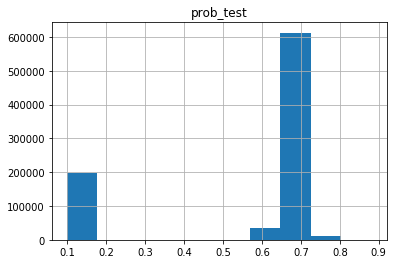

In [25]:
df_av.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f203e2f3a20>,
      dtype=object)

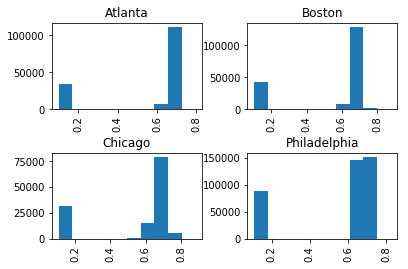

In [26]:
df_av.hist(by='city')

In [27]:
df_av.describe()

,prob_test
count,857409.000000
mean,0.552628
std,0.232949
min,0.098977
25%,0.636675
50%,0.673020
75%,0.687935
max,0.881125


** Step 4 **

There are about 200000 train data entries with a 0.1 probability to be similar to test. Looking at the histograms we dismiss every data entry with less then 0.5 test-probability for the detailed model later on.
The 0.5 threshold out of adversarial validation only worked on the detailed model. The general model did a simple validation-split by row number.

## Remove Outliers from train
**!! This approach unfortunately didn't advance the model and was left out for the final model !!**

The main idea is to analyse the target values (TotalTimeStopped and DistanceToFirstStop) and considere values above the 99.x-quantil as outliers and use this value as either a cutoff (clip)-value for the predicted targets or remove them from the train data. In both cases the model didn't improve.

** Step 1 **

Mark rows with target value > 99.5-percentile. Group by City-Cluster-1 to calculate quantil.

(I needed to split SQL because of CPU-usage restriction on free tier.)

### TotalTimeStopped
using q=0.995

In [28]:
%%bigquery tts_q
SELECT
c.city_cluster_1,
count(1)cnt,
min(TotalTimeStopped_p20) tts20_min,
max(TotalTimeStopped_p20) tts20_max,
avg(TotalTimeStopped_p20) tts20_avg,
stddev(TotalTimeStopped_p20) tts20_std,
APPROX_QUANTILES(TotalTimeStopped_p20,201)[SAFE_ORDINAL(200)] tts20_q99,

min(TotalTimeStopped_p50) tts50_min,
max(TotalTimeStopped_p50) tts50_max,
avg(TotalTimeStopped_p50) tts50_avg,
stddev(TotalTimeStopped_p50) tts50_std,
APPROX_QUANTILES(TotalTimeStopped_p50,201)[SAFE_ORDINAL(200)] tts50_q99,

min(TotalTimeStopped_p80) tts80_min,
max(TotalTimeStopped_p80) tts80_max,
avg(TotalTimeStopped_p80) tts80_avg,
stddev(TotalTimeStopped_p80) tts80_std,
APPROX_QUANTILES(TotalTimeStopped_p80,201)[SAFE_ORDINAL(200)] tts80_q99

FROM
  `kaggle-competition-datasets.geotab_intersection_congestion.train` t,
  `bqml_example.city_cluster` c
WHERE
  c.city = c.city
  AND t.intersectionid=t.intersectionid
GROUP BY
  c.city_cluster_1;

In [29]:
tts_q.describe()

,cnt,tts20_min,tts20_max,tts20_avg,tts20_std,tts20_q99,tts50_min,tts50_max,tts50_avg,tts50_std,tts50_q99,tts80_min,tts80_max,tts80_avg,tts80_std,tts80_q99
count,8.000000e+01,80.0,80.0,8.000000e+01,8.000000e+01,80.000000,80.0,80.0,8.000000e+01,8.000000e+01,80.000000,80.0,80.0,8.000000e+01,8.000000e+01,80.000000
mean,6.838909e+07,0.0,273.0,1.731272e+00,7.080013e+00,35.087500,0.0,343.0,7.681874e+00,1.555341e+01,67.825000,0.0,689.0,2.294807e+01,2.811812e+01,122.075000
std,4.858926e+07,0.0,0.0,2.791057e-15,8.496213e-08,0.284349,0.0,0.0,9.994287e-15,1.866452e-07,0.382364,0.0,0.0,3.159491e-14,3.374253e-07,0.347687
min,8.574090e+06,0.0,273.0,1.731272e+00,7.080013e+00,35.000000,0.0,343.0,7.681874e+00,1.555341e+01,67.000000,0.0,689.0,2.294807e+01,2.811812e+01,121.000000
25%,3.150978e+07,0.0,273.0,1.731272e+00,7.080013e+00,35.000000,0.0,343.0,7.681874e+00,1.555341e+01,68.000000,0.0,689.0,2.294807e+01,2.811812e+01,122.000000
50%,6.001863e+07,0.0,273.0,1.731272e+00,7.080013e+00,35.000000,0.0,343.0,7.681874e+00,1.555341e+01,68.000000,0.0,689.0,2.294807e+01,2.811812e+01,122.000000
75%,9.109971e+07,0.0,273.0,1.731272e+00,7.080013e+00,35.000000,0.0,343.0,7.681874e+00,1.555341e+01,68.000000,0.0,689.0,2.294807e+01,2.811812e+01,122.000000
max,2.555079e+08,0.0,273.0,1.731272e+00,7.080013e+00,36.000000,0.0,343.0,7.681874e+00,1.555341e+01,68.000000,0.0,689.0,2.294807e+01,2.811812e+01,123.000000


Since stddev of q99 is small I use the same filter values for all city clusters.

Define filter to remove outliers:

In [30]:
tts20_outlier_filter = tts_q['tts20_q99'].max()
tts50_outlier_filter = tts_q['tts50_q99'].max()
tts80_outlier_filter = tts_q['tts80_q99'].max()

print('TotalTimeStopped_20 filter:', tts20_outlier_filter)
print('TotalTimeStopped_50 filter:', tts50_outlier_filter)
print('TotalTimeStopped_80 filter:', tts80_outlier_filter)

TotalTimeStopped_20 filter: 36
TotalTimeStopped_50 filter: 68
TotalTimeStopped_80 filter: 123


### DistanceToFirstStop
q=0.995

In [31]:
%%bigquery dts_q20
SELECT
c.city_cluster_1,
count(1)cnt,
min(DistanceToFirstStop_p20) dts20_min,
max(DistanceToFirstStop_p20) dts20_max,
avg(DistanceToFirstStop_p20) dts20_avg,
stddev(DistanceToFirstStop_p20) dts20_std,
APPROX_QUANTILES(DistanceToFirstStop_p20,201)[SAFE_ORDINAL(200)] dts20_q99
FROM
  `kaggle-competition-datasets.geotab_intersection_congestion.train` t,
  `bqml_example.city_cluster` c
WHERE
  c.city = c.city
  AND t.intersectionid=t.intersectionid
GROUP BY
  c.city_cluster_1

In [32]:
dts_q20.describe()

,cnt,dts20_min,dts20_max,dts20_avg,dts20_std,dts20_q99
count,8.000000e+01,80.0,80.0,8.000000e+01,8.000000e+01,80.000000
mean,6.838909e+07,0.0,1902.7,6.564450e+00,2.800324e+01,94.367500
std,4.858926e+07,0.0,0.0,9.221562e-15,3.360467e-07,0.155714
min,8.574090e+06,0.0,1902.7,6.564450e+00,2.800324e+01,94.000000
25%,3.150978e+07,0.0,1902.7,6.564450e+00,2.800324e+01,94.300000
50%,6.001863e+07,0.0,1902.7,6.564450e+00,2.800324e+01,94.400000
75%,9.109971e+07,0.0,1902.7,6.564450e+00,2.800324e+01,94.500000
max,2.555079e+08,0.0,1902.7,6.564450e+00,2.800325e+01,94.800000


In [33]:
%%bigquery dts_q50
SELECT
c.city_cluster_1,
count(1)cnt,
min(DistanceToFirstStop_p50) dts50_min,
max(DistanceToFirstStop_p50) dts50_max,
avg(DistanceToFirstStop_p50) dts50_avg,
stddev(DistanceToFirstStop_p50) dts50_std,
APPROX_QUANTILES(DistanceToFirstStop_p50,201)[SAFE_ORDINAL(200)] dts50_q99
FROM
  `kaggle-competition-datasets.geotab_intersection_congestion.train` t,
  `bqml_example.city_cluster` c
WHERE
  c.city = c.city
  AND t.intersectionid=t.intersectionid
GROUP BY
  c.city_cluster_1;

In [34]:
dts_q50.describe()

,cnt,dts50_min,dts50_max,dts50_avg,dts50_std,dts50_q99
count,8.000000e+01,80.0,80.0,8.000000e+01,8.000000e+01,80.000000
mean,6.838909e+07,0.0,3099.5,2.825585e+01,7.172005e+01,321.066250
std,4.858926e+07,0.0,0.0,3.131811e-14,8.606605e-07,1.327408
min,8.574090e+06,0.0,3099.5,2.825585e+01,7.172005e+01,318.500000
25%,3.150978e+07,0.0,3099.5,2.825585e+01,7.172005e+01,319.875000
50%,6.001863e+07,0.0,3099.5,2.825585e+01,7.172005e+01,321.000000
75%,9.109971e+07,0.0,3099.5,2.825585e+01,7.172005e+01,322.000000
max,2.555079e+08,0.0,3099.5,2.825585e+01,7.172005e+01,323.800000


In [35]:
%%bigquery dts_q80
SELECT
c.city_cluster_1,
count(1)cnt,
min(DistanceToFirstStop_p80) dts80_min,
max(DistanceToFirstStop_p80) dts80_max,
avg(DistanceToFirstStop_p80) dts80_avg,
stddev(DistanceToFirstStop_p80) dts80_std,
APPROX_QUANTILES(DistanceToFirstStop_p80,201)[SAFE_ORDINAL(200)] dts80_q99
FROM
  `kaggle-competition-datasets.geotab_intersection_congestion.train` t,
  `bqml_example.city_cluster` c
WHERE
  c.city = c.city
  AND t.intersectionid=t.intersectionid
GROUP BY
  c.city_cluster_1;

In [36]:
dts_q80.describe()

,cnt,dts80_min,dts80_max,dts80_avg,dts80_std,dts80_q99
count,8.000000e+01,80.0,8.000000e+01,8.000000e+01,80.000000,80.000000
mean,6.838909e+07,0.0,4.064300e+03,8.192264e+01,152.682673,828.427500
std,4.858926e+07,0.0,5.949014e-12,8.655946e-14,0.000002,2.118751
min,8.574090e+06,0.0,4.064300e+03,8.192264e+01,152.682671,824.600000
25%,3.150978e+07,0.0,4.064300e+03,8.192264e+01,152.682672,826.875000
50%,6.001863e+07,0.0,4.064300e+03,8.192264e+01,152.682672,828.200000
75%,9.109971e+07,0.0,4.064300e+03,8.192264e+01,152.682673,830.025000
max,2.555079e+08,0.0,4.064300e+03,8.192264e+01,152.682680,833.800000


Since stddev of q99 is small I use the same filter values for all city clusters.

Define filter to remove outliers:

In [37]:
dts20_outlier_filter = dts_q20['dts20_q99'].max()
dts50_outlier_filter = dts_q50['dts50_q99'].max()
dts80_outlier_filter = dts_q80['dts80_q99'].max()

print('DistanceToFirstStop_20 filter:', dts20_outlier_filter)
print('DistanceToFirstStop_50 filter:', dts50_outlier_filter)
print('DistanceToFirstStop_80 filter:', dts80_outlier_filter)

DistanceToFirstStop_20 filter: 94.8
DistanceToFirstStop_50 filter: 323.8
DistanceToFirstStop_80 filter: 833.8


In [38]:
outliers_filter = {'TotalTimeStopped_p20':tts20_outlier_filter,
                   'TotalTimeStopped_p50':tts50_outlier_filter,
                   'TotalTimeStopped_p80':tts80_outlier_filter,
                   'DistanceToFirstStop_p20':dts20_outlier_filter,
                   'DistanceToFirstStop_p50':dts50_outlier_filter,
                   'DistanceToFirstStop_p80':dts80_outlier_filter}

outliers_filter

{'TotalTimeStopped_p20': 36,
 'TotalTimeStopped_p50': 68,
 'TotalTimeStopped_p80': 123,
 'DistanceToFirstStop_p20': 94.8,
 'DistanceToFirstStop_p50': 323.8,
 'DistanceToFirstStop_p80': 833.8}

# Build models
(The idea of creating a general and a detailed model depending on intersection and street informations was derived from https://www.kaggle.com/gaborfodor/4-xgboost-general)

## Detailed model
The detailed prediction model is trained with data where the intersections and streets are also known in the test data set.
The entire dataset above the 0.5 adversarial threshold is used for train. Usualy I'd keep some amount for validation. But I dismissed it (as well as cross validatin) because of limited BQ quota. I only tried a couple of different hyper parameters for the same reason. The default settings fit best.

In [39]:
%%time
#model_changed = False

if model_changed:
    print("Let's go")

    for mn in mod_names:
        sql="""
        CREATE OR REPLACE MODEL `bqml_example.model_"""+mn+"""`
        OPTIONS(MODEL_TYPE='linear_reg') AS 
        SELECT  t."""+mn+""" as label,
                concat(t.city,cast(t.intersectionid as string)) i_id,
                cc.city_cluster_1,
                cc.city_cluster_2,
                cc.city_cluster_3,
                cc.city_cluster_4,
                cc.city_cluster_5,
                t.city,
                t.hour,
                t.weekend,
                t.month,
                --(case 
                --    when t.hour between 6 and 9 then 'RUSH_HOUR_MORNING'
                --    when t.hour between 10 and 15 then 'MIDDAY'
                --    when t.hour between 16 and 19 then 'RUSH_HOUR_EVENING'
                --    else 'NIGHT'
                --end) daytime,
                --(case 
                --    when t.month between 4 and 6 then 'SPRING'
                --    when t.month between 7 and 9 then 'SUMMER'
                --    when t.month between 10 and 11 then 'FALL'
                --    else 'WINTER'
                --end) season,
                `bqml_example.direction`(t.entryheading, t.exitheading) direction,
                --`bqml_example.road_encode`(t.entrystreetname) road_type_entry,
                --`bqml_example.road_encode`(t.exitstreetname) road_type_exit,
                t.entryheading,
                t.exitheading,
                round(sin(bqml_example.direction2degree(`bqml_example.direction`(t.entryheading, t.exitheading))*ACOS(-1)/180),6) direction_sin,
                round(cos(bqml_example.direction2degree(`bqml_example.direction`(t.entryheading, t.exitheading))*ACOS(-1)/180),6) direction_cos,
                round(sin(bqml_example.direction2degree(t.entryheading)*ACOS(-1)/180),6) entryheading_sin,
                round(cos(bqml_example.direction2degree(t.entryheading)*ACOS(-1)/180),6) entryheading_cos,
                round(sin(bqml_example.direction2degree(t.exitheading)*ACOS(-1)/180),6) exitheading_sin,
                round(cos(bqml_example.direction2degree(t.exitheading)*ACOS(-1)/180),6) exitheading_cos,
                round(cc.dist_to_cluster_center_1,8) dist_to_cluster_center_1,
                round(cc.dist_to_cluster_center_2,8) dist_to_cluster_center_2,
                round(cc.dist_to_cluster_center_3,8) dist_to_cluster_center_3,
                round(cc.dist_to_cluster_center_4,8) dist_to_cluster_center_4,
                round(cc.dist_to_cluster_center_5,8) dist_to_cluster_center_5,
                intersections_per_cluster_1,
                intersections_per_cluster_2,
                intersections_per_cluster_3,
                intersections_per_cluster_4,
                intersections_per_cluster_5,
                count(1)over(partition by t.city, t.hour) / count(1)over(partition by t.city) observation_ratio_per_city,
                zp.population,
                zp.zipcode,
                zp.intersections_per_zipcode,
                zp.pop_intersec_ratio,
                zp.zip_code_na,
                concat(t.city,t.path) as path,
                concat(t.city,t.entryStreetName) as entry_street_name,
                concat(t.city,t.exitStreetName) as exit_street_name,
                case when t.entryStreetName = t.exitStreetName then
                    1
                else
                    0
                end as same_street,
                zp.num_observations,
                a.app_st_length,
                a.app_st_length_fallback
          FROM `bqml_example.city_cluster` cc,
               `kaggle-competition-datasets.geotab_intersection_congestion.train` t,
               `bqml_example.testalike_av` av,
               `bqml_example.zipcode_population` zp,
               `bqml_example.approching_street_imputed` a
         WHERE t.city = cc.city
           AND t.intersectionid = cc.intersectionid
           AND t.intersectionid = zp.intersectionid
           AND t.city = zp.city
           AND t.rowid = av.rowid
           AND av.prob_test > 0.5
           AND ifnull(t.intersectionid, -99 ) = ifnull(a.intersectionid,-99)
           AND t.city = a.city
           AND ifnull(t.ExitStreetName,'#_#') = ifnull(a.ExitStreetName,'#_#')
           AND ifnull(t.ExitHeading,'#_#') = ifnull(a.ExitHeading,'#_#')
           AND ifnull(t.EntryStreetName,'#_#') = ifnull(a.EntryStreetName,'#_#')
           AND ifnull(t.EntryHeading,'#_#') = ifnull(a.EntryHeading,'#_#')
        """
        
        client.query(sql).result()

        print('Done with',mn)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 12.6 µs


## General Model

For the test data that doesn't match intersections, path, entry and exit streets from train I build a more general model. BATCH_GRADIENT_DESCENT needs to be forced on this model, otherwise with the default optimize strategie the outliers in the prediction are very high. For this model the train-validation-split is done by rowid (split by adversiarial validation didn't improve the general model).

In [40]:
%%time
#model_changed = False

if model_changed:
    print("Let's go")

    for mn in mod_names:
        sql="""
        CREATE OR REPLACE MODEL `bqml_example.model_"""+mn+"""_general`
        OPTIONS(MODEL_TYPE='linear_reg',L2_REG=0.2,
                LS_INIT_LEARN_RATE=0.4,
                OPTIMIZE_STRATEGY='BATCH_GRADIENT_DESCENT') AS 
        SELECT  t."""+mn+""" as label,
                t.Longitude,
                t.Latitude, 
                cc.city_cluster_1,
                cc.city_cluster_2,
                cc.city_cluster_3,
                cc.city_cluster_4,
                cc.city_cluster_5,
                t.city,
                t.hour,
                t.weekend,
                t.month,
                `bqml_example.direction`(t.entryheading, t.exitheading) direction,
                --`bqml_example.road_encode`(t.entrystreetname) road_type_entry,
                --`bqml_example.road_encode`(t.exitstreetname) road_type_exit,
                t.entryheading,
                t.exitheading,
                round(sin(bqml_example.direction2degree(`bqml_example.direction`(t.entryheading, t.exitheading))*ACOS(-1)/180),6) direction_sin,
                round(cos(bqml_example.direction2degree(`bqml_example.direction`(t.entryheading, t.exitheading))*ACOS(-1)/180),6) direction_cos,
                round(sin(bqml_example.direction2degree(t.entryheading)*ACOS(-1)/180),6) entryheading_sin,
                round(cos(bqml_example.direction2degree(t.entryheading)*ACOS(-1)/180),6) entryheading_cos,
                round(sin(bqml_example.direction2degree(t.exitheading)*ACOS(-1)/180),6) exitheading_sin,
                round(cos(bqml_example.direction2degree(t.exitheading)*ACOS(-1)/180),6) exitheading_cos,
                round(cc.dist_to_cluster_center_1,8) dist_to_cluster_center_1,
                round(cc.dist_to_cluster_center_2,8) dist_to_cluster_center_2,
                round(cc.dist_to_cluster_center_3,8) dist_to_cluster_center_3,
                round(cc.dist_to_cluster_center_4,8) dist_to_cluster_center_4,
                round(cc.dist_to_cluster_center_5,8) dist_to_cluster_center_5,
                intersections_per_cluster_1,
                intersections_per_cluster_2,
                intersections_per_cluster_3,
                intersections_per_cluster_4,
                intersections_per_cluster_5,
                count(1)over(partition by t.city, t.hour) / count(1)over(partition by t.city) observation_ratio_per_city,
                zp.population,
                zp.zipcode,
                zp.intersections_per_zipcode,
                zp.pop_intersec_ratio,
                zp.zip_code_na,
                case when t.entryStreetName = t.exitStreetName then
                    1
                else
                    0
                end as same_street,
                zp.num_observations,
                a.app_st_length,
                a.app_st_length_fallback
          FROM `bqml_example.city_cluster` cc,
               `kaggle-competition-datasets.geotab_intersection_congestion.train` t,
               `bqml_example.testalike_av` av,
               `bqml_example.zipcode_population` zp,
               `bqml_example.approching_street_imputed` a
         WHERE t.city = cc.city
           AND t.intersectionid = cc.intersectionid
           AND t.intersectionid = zp.intersectionid
           AND t.city = zp.city
           AND t.rowid = av.rowid
           and t.rowid < 2600000
           AND ifnull(t.intersectionid, -99 ) = ifnull(a.intersectionid,-99)
           AND t.city = a.city
           AND ifnull(t.ExitStreetName,'#_#') = ifnull(a.ExitStreetName,'#_#')
           AND ifnull(t.ExitHeading,'#_#') = ifnull(a.ExitHeading,'#_#')
           AND ifnull(t.EntryStreetName,'#_#') = ifnull(a.EntryStreetName,'#_#')
           AND ifnull(t.EntryHeading,'#_#') = ifnull(a.EntryHeading,'#_#')
        """
        #
         #  AND av.prob_test > 0.5
         #  AND t."""+mn+""" <= """+str(outliers_filter[mn])+"""
        #between 0.5 and 0.85
    #< 2600000;
        client.query(sql).result()

        print('Done with',mn)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 12.9 µs


## Get training statistics
For example TotalTimeStopped_p20 is shown in the notebook. Evaluation on the other models was done for convenience in the BigQuery console.

In [41]:
%%time
%%bigquery
SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `bqml_example.model_TotalTimeStopped_p20`)
ORDER BY iteration 

CPU times: user 40 ms, sys: 8 ms, total: 48 ms
Wall time: 844 ms


,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,0,43.395014,43.713144,0.1,16236
1,0,1,40.068919,40.717962,0.1,25969
2,0,2,38.095899,39.215629,0.1,28831
3,0,3,36.331866,38.082470,0.2,35575
4,0,4,35.297734,37.378882,0.1,24200
5,0,5,34.657681,36.942462,0.1,24270
6,0,6,34.214005,36.721812,0.1,25094


In [42]:
%%time
%%bigquery
SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `bqml_example.model_TotalTimeStopped_p20_general`)
ORDER BY iteration 

CPU times: user 48 ms, sys: 0 ns, total: 48 ms
Wall time: 810 ms


,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,0,54.175246,53.323952,0.1,16001
1,0,1,53.004843,52.204704,0.2,20132
2,0,2,52.483496,51.640820,0.1,21480
3,0,3,52.174864,51.334427,0.2,20154


In [43]:
%%time
%%bigquery
SELECT
  *
FROM
  ML.FEATURE_INFO(MODEL `bqml_example.model_TotalTimeStopped_p20`)

CPU times: user 40 ms, sys: 8 ms, total: 48 ms
Wall time: 750 ms


,input,min,max,mean,median,stddev,category_count,null_count
0,i_id,NaN,NaN,NaN,NaN,NaN,4334.0,NaN
1,city_cluster_1,NaN,NaN,NaN,NaN,NaN,60.0,NaN
2,city_cluster_2,NaN,NaN,NaN,NaN,NaN,65.0,NaN
3,city_cluster_3,NaN,NaN,NaN,NaN,NaN,68.0,NaN
4,city_cluster_4,NaN,NaN,NaN,NaN,NaN,70.0,NaN
5,city_cluster_5,NaN,NaN,NaN,NaN,NaN,72.0,NaN
6,city,NaN,NaN,NaN,NaN,NaN,4.0,NaN
7,hour,0.000000,23.000000,12.479479,13.000000,6.084951,NaN,0.0
8,weekend,NaN,NaN,NaN,NaN,NaN,2.0,NaN
9,month,1.000000,12.000000,9.111451,9.000000,1.990438,NaN,0.0


In [44]:
%%bigquery
SELECT
  *
FROM
  ML.WEIGHTS(MODEL  `bqml_example.model_TotalTimeStopped_p20`,
    STRUCT(true AS standardize))

,processed_input,weight,category_weights
0,i_id,NaN,"[{'category': 'Chicago2222', 'weight': 0.98220..."
1,city_cluster_1,NaN,"[{'category': 'Boston_2', 'weight': 0.00870124..."
2,city_cluster_2,NaN,"[{'category': 'Philadelphia_9', 'weight': 0.02..."
3,city_cluster_3,NaN,"[{'category': 'Atlanta_1', 'weight': -0.036220..."
4,city_cluster_4,NaN,"[{'category': 'Philadelphia_16', 'weight': 0.0..."
5,city_cluster_5,NaN,"[{'category': 'Philadelphia_4', 'weight': 0.08..."
6,city,NaN,"[{'category': 'Chicago', 'weight': 0.135174662..."
7,hour,0.079943,[]
8,weekend,NaN,"[{'category': 'false', 'weight': 0.16234420417..."
9,month,-0.039554,[]


## Evaluating the model
Since I didn't leave out an appropriate validation set (e.g. top 10% of the test-alike train data) the evaluation is not a good indicator for the leaderboard. I rather used it briefly to check for slight improvments to the previous run. This is definitely a shortcoming of this kernel.


### General model

In [45]:
# Using data below adversarial threshold as validation set :-/ 
sql="""SELECT
          *
        FROM ML.EVALUATE(MODEL `bqml_example.model_TotalTimeStopped_p20`, (
        SELECT  t.TotalTimeStopped_p20 as label, 
                concat(t.city,cast(t.intersectionid as string)) i_id,
                cc.city_cluster_1,
                cc.city_cluster_2,
                cc.city_cluster_3,
                cc.city_cluster_4,
                cc.city_cluster_5,
                t.city,
                t.hour,
                t.weekend,
                t.month,
                --(case 
                --    when t.hour between 6 and 9 then 'RUSH_HOUR_MORNING'
                --   when t.hour between 10 and 15 then 'MIDDAY'
                --    when t.hour between 16 and 19 then 'RUSH_HOUR_EVENING'
                --    else 'NIGHT'
                --end) daytime,
                --(case 
                --    when t.month between 4 and 6 then 'SPRING'
                --    when t.month between 7 and 9 then 'SUMMER'
                --    when t.month between 10 and 11 then 'FALL'
                --    else 'WINTER'
                --end) season,
                `bqml_example.direction`(t.entryheading, t.exitheading) direction,
                --`bqml_example.road_encode`(t.entrystreetname) road_type_entry,
                --`bqml_example.road_encode`(t.exitstreetname) road_type_exit,
                t.entryheading,
                t.exitheading,
                round(sin(bqml_example.direction2degree(`bqml_example.direction`(t.entryheading, t.exitheading))*ACOS(-1)/180),6) direction_sin,
                round(cos(bqml_example.direction2degree(`bqml_example.direction`(t.entryheading, t.exitheading))*ACOS(-1)/180),6) direction_cos,
                round(sin(bqml_example.direction2degree(t.entryheading)*ACOS(-1)/180),6) entryheading_sin,
                round(cos(bqml_example.direction2degree(t.entryheading)*ACOS(-1)/180),6) entryheading_cos,
                round(sin(bqml_example.direction2degree(t.exitheading)*ACOS(-1)/180),6) exitheading_sin,
                round(cos(bqml_example.direction2degree(t.exitheading)*ACOS(-1)/180),6) exitheading_cos,
                round(cc.dist_to_cluster_center_1,8) dist_to_cluster_center_1,
                round(cc.dist_to_cluster_center_2,8) dist_to_cluster_center_2,
                round(cc.dist_to_cluster_center_3,8) dist_to_cluster_center_3,
                round(cc.dist_to_cluster_center_4,8) dist_to_cluster_center_4,
                round(cc.dist_to_cluster_center_5,8) dist_to_cluster_center_5,
                intersections_per_cluster_1,
                intersections_per_cluster_2,
                intersections_per_cluster_3,
                intersections_per_cluster_4,
                intersections_per_cluster_5,
                count(1)over(partition by t.city, t.hour) / count(1)over(partition by t.city) observation_ratio_per_city,
                zp.population,
                zp.zipcode,
                zp.intersections_per_zipcode,
                zp.pop_intersec_ratio,
                zp.zip_code_na,
                concat(t.city,t.path) as path,
                concat(t.city,t.entryStreetName) as entry_street_name,
                concat(t.city,t.exitStreetName) as exit_street_name,
                case when t.entryStreetName = t.exitStreetName then
                    1
                else
                    0
                end as same_street,
                zp.num_observations,
                a.app_st_length,
                a.app_st_length_fallback
  FROM `bqml_example.city_cluster` cc,
               `kaggle-competition-datasets.geotab_intersection_congestion.train` t,
               `bqml_example.testalike_av` av,
               `bqml_example.zipcode_population` zp,
               `bqml_example.approching_street_imputed` a
         WHERE t.city = cc.city
           AND t.intersectionid = cc.intersectionid
           AND t.intersectionid = zp.intersectionid
           AND t.city = zp.city
           AND t.rowid = av.rowid
           AND av.prob_test <= 0.5
           AND ifnull(t.intersectionid, -99 ) = ifnull(a.intersectionid,-99)
           AND t.city = a.city
           AND ifnull(t.ExitStreetName,'#_#') = ifnull(a.ExitStreetName,'#_#')
           AND ifnull(t.ExitHeading,'#_#') = ifnull(a.ExitHeading,'#_#')
           AND ifnull(t.EntryStreetName,'#_#') = ifnull(a.EntryStreetName,'#_#')
           AND ifnull(t.EntryHeading,'#_#') = ifnull(a.EntryHeading,'#_#')))"""

client.query(sql).to_dataframe()

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,3.163201,58.088947,1.15869,1.313035,0.018705,0.023481


### General model

In [46]:
# validation set by rowid
sql="""SELECT
          *
        FROM ML.EVALUATE(MODEL `bqml_example.model_TotalTimeStopped_p20_general`, (
        SELECT  t.TotalTimeStopped_p20 as label, 
                t.Longitude,
                t.Latitude, 
                cc.city_cluster_1,
                cc.city_cluster_2,
                cc.city_cluster_3,
                cc.city_cluster_4,
                cc.city_cluster_5,
                t.city,
                t.hour,
                t.weekend,
                t.month,
                `bqml_example.direction`(t.entryheading, t.exitheading) direction,
                --`bqml_example.road_encode`(t.entrystreetname) road_type_entry,
                --`bqml_example.road_encode`(t.exitstreetname) road_type_exit,
                t.entryheading,
                t.exitheading,
                round(sin(bqml_example.direction2degree(`bqml_example.direction`(t.entryheading, t.exitheading))*ACOS(-1)/180),6) direction_sin,
                round(cos(bqml_example.direction2degree(`bqml_example.direction`(t.entryheading, t.exitheading))*ACOS(-1)/180),6) direction_cos,
                round(sin(bqml_example.direction2degree(t.entryheading)*ACOS(-1)/180),6) entryheading_sin,
                round(cos(bqml_example.direction2degree(t.entryheading)*ACOS(-1)/180),6) entryheading_cos,
                round(sin(bqml_example.direction2degree(t.exitheading)*ACOS(-1)/180),6) exitheading_sin,
                round(cos(bqml_example.direction2degree(t.exitheading)*ACOS(-1)/180),6) exitheading_cos,
                round(cc.dist_to_cluster_center_1,8) dist_to_cluster_center_1,
                round(cc.dist_to_cluster_center_2,8) dist_to_cluster_center_2,
                round(cc.dist_to_cluster_center_3,8) dist_to_cluster_center_3,
                round(cc.dist_to_cluster_center_4,8) dist_to_cluster_center_4,
                round(cc.dist_to_cluster_center_5,8) dist_to_cluster_center_5,
                intersections_per_cluster_1,
                intersections_per_cluster_2,
                intersections_per_cluster_3,
                intersections_per_cluster_4,
                intersections_per_cluster_5,
                count(1)over(partition by t.city, t.hour) / count(1)over(partition by t.city) observation_ratio_per_city,
                zp.population,
                zp.zipcode,
                zp.intersections_per_zipcode,
                zp.pop_intersec_ratio,
                zp.zip_code_na,
                case when t.entryStreetName = t.exitStreetName then
                    1
                else
                    0
                end as same_street,
                zp.num_observations,
                a.app_st_length,
                a.app_st_length_fallback
  FROM `bqml_example.city_cluster` cc,
               `kaggle-competition-datasets.geotab_intersection_congestion.train` t,
               `bqml_example.testalike_av` av,
               `bqml_example.zipcode_population` zp,
               `bqml_example.approching_street_imputed` a
         WHERE t.city = cc.city
           AND t.intersectionid = cc.intersectionid
           AND t.intersectionid = zp.intersectionid
           AND t.city = zp.city
           AND t.rowid = av.rowid
           and t.rowid >= 2600000
           AND ifnull(t.intersectionid, -99 ) = ifnull(a.intersectionid,-99)
           AND t.city = a.city
           AND ifnull(t.ExitStreetName,'#_#') = ifnull(a.ExitStreetName,'#_#')
           AND ifnull(t.ExitHeading,'#_#') = ifnull(a.ExitHeading,'#_#')
           AND ifnull(t.EntryStreetName,'#_#') = ifnull(a.EntryStreetName,'#_#')
           AND ifnull(t.EntryHeading,'#_#') = ifnull(a.EntryHeading,'#_#')
           ))"""

#AND av.prob_test <= 0.5

client.query(sql).to_dataframe()

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,2.543738,29.014786,1.130309,1.28713,0.020022,0.021582


# Predict outcomes
Predict the target values and generate the output file. Use detailed model for test data with intersection_id, path, exit and entry street existing in train. Use general model otherwise. Clip negative values to 0.


In [47]:
def pred(mn, debug=False):
    
    if debug:
        lmt='LIMIT 10'
    else:
        lmt=''
    
    ## Detailed model
    
    sql="""
    SELECT
      RowId,
      case when predicted_label < 0 then 
          0 
      else 
          predicted_label 
      end as """+mn+"""
    FROM
      ML.PREDICT(MODEL `bqml_example.model_"""+mn+"""`,
        (
        SELECT  t.RowId, 
                concat(t.city,cast(t.intersectionid as string)) i_id,
                cc.city_cluster_1,
                cc.city_cluster_2,
                cc.city_cluster_3,
                cc.city_cluster_4,
                cc.city_cluster_5,
                t.city,
                t.hour,
                t.weekend,
                t.month,
                --(case 
                --    when t.hour between 6 and 9 then 'RUSH_HOUR_MORNING'
                --    when t.hour between 10 and 15 then 'MIDDAY'
                --    when t.hour between 16 and 19 then 'RUSH_HOUR_EVENING'
                --    else 'NIGHT'
                --end) daytime,
                --(case 
                --    when t.month between 4 and 6 then 'SPRING'
                --    when t.month between 7 and 9 then 'SUMMER'
                --    when t.month between 10 and 11 then 'FALL'
                --    else 'WINTER'
                --end) season,
                `bqml_example.direction`(t.entryheading, t.exitheading) direction,
                --`bqml_example.road_encode`(t.entrystreetname) road_type_entry,
                --`bqml_example.road_encode`(t.exitstreetname) road_type_exit,
                t.entryheading,
                t.exitheading,
                round(sin(bqml_example.direction2degree(`bqml_example.direction`(t.entryheading, t.exitheading))*ACOS(-1)/180),6) direction_sin,
                round(cos(bqml_example.direction2degree(`bqml_example.direction`(t.entryheading, t.exitheading))*ACOS(-1)/180),6) direction_cos,
                round(sin(bqml_example.direction2degree(t.entryheading)*ACOS(-1)/180),6) entryheading_sin,
                round(cos(bqml_example.direction2degree(t.entryheading)*ACOS(-1)/180),6) entryheading_cos,
                round(sin(bqml_example.direction2degree(t.exitheading)*ACOS(-1)/180),6) exitheading_sin,
                round(cos(bqml_example.direction2degree(t.exitheading)*ACOS(-1)/180),6) exitheading_cos,
                round(cc.dist_to_cluster_center_1,8) dist_to_cluster_center_1,
                round(cc.dist_to_cluster_center_2,8) dist_to_cluster_center_2,
                round(cc.dist_to_cluster_center_3,8) dist_to_cluster_center_3,
                round(cc.dist_to_cluster_center_4,8) dist_to_cluster_center_4,
                round(cc.dist_to_cluster_center_5,8) dist_to_cluster_center_5,
                intersections_per_cluster_1,
                intersections_per_cluster_2,
                intersections_per_cluster_3,
                intersections_per_cluster_4,
                intersections_per_cluster_5,
                count(1)over(partition by t.city, t.hour) / count(1)over(partition by t.city) observation_ratio_per_city,
                zp.population,
                zp.zipcode,
                zp.intersections_per_zipcode,
                zp.pop_intersec_ratio,
                zp.zip_code_na,
                concat(t.city,t.path) as path,
                concat(t.city,t.entryStreetName) as entry_street_name,
                concat(t.city,t.exitStreetName) as exit_street_name,
                case when t.entryStreetName = t.exitStreetName then
                    1
                else
                    0
                end as same_street,
                zp.num_observations,
                a.app_st_length,
                a.app_st_length_fallback
          FROM `bqml_example.city_cluster` cc,
               `kaggle-competition-datasets.geotab_intersection_congestion.test` t,
               `bqml_example.zipcode_population` zp,
               `bqml_example.approching_street_imputed` a
         WHERE t.city = cc.city
           AND t.intersectionid = cc.intersectionid
           AND t.intersectionid = zp.intersectionid
           AND t.city = zp.city
           AND ifnull(t.intersectionid, -99 ) = ifnull(a.intersectionid,-99)
           AND t.city = a.city
           AND ifnull(t.ExitStreetName,'#_#') = ifnull(a.ExitStreetName,'#_#')
           AND ifnull(t.ExitHeading,'#_#') = ifnull(a.ExitHeading,'#_#')
           AND ifnull(t.EntryStreetName,'#_#') = ifnull(a.EntryStreetName,'#_#')
           AND ifnull(t.EntryHeading,'#_#') = ifnull(a.EntryHeading,'#_#')
           AND    EXISTS (
                  SELECT
                    1
                  FROM
                    `kaggle-competition-datasets.geotab_intersection_congestion.train` n
                  WHERE
                    n.IntersectionId = t.IntersectionId
                    and n.EntryStreetName = t.EntryStreetName
                    AND n.ExitStreetName = t.ExitStreetName
                    AND n.Path = t.path)
                          
          """+lmt+"""))
        ORDER BY RowId ASC"""
    
    df=client.query(sql).to_dataframe()

    ## general model
    
    sql="""
    SELECT
      RowId,
      case when predicted_label < 0 then 
          0 
      else 
          predicted_label 
      end as """+mn+"""
    FROM
      ML.PREDICT(MODEL `bqml_example.model_"""+mn+"""_general`,
        (
        SELECT  t.RowId, 
                t.Longitude,
                t.Latitude, 
                cc.city_cluster_1,
                cc.city_cluster_2,
                cc.city_cluster_3,
                cc.city_cluster_4,
                cc.city_cluster_5,
                t.city,
                t.hour,
                t.weekend,
                t.month,
                `bqml_example.direction`(t.entryheading, t.exitheading) direction,
                --`bqml_example.road_encode`(t.entrystreetname) road_type_entry,
                --`bqml_example.road_encode`(t.exitstreetname) road_type_exit,
                t.entryheading,
                t.exitheading,
                round(sin(bqml_example.direction2degree(`bqml_example.direction`(t.entryheading, t.exitheading))*ACOS(-1)/180),6) direction_sin,
                round(cos(bqml_example.direction2degree(`bqml_example.direction`(t.entryheading, t.exitheading))*ACOS(-1)/180),6) direction_cos,
                round(sin(bqml_example.direction2degree(t.entryheading)*ACOS(-1)/180),6) entryheading_sin,
                round(cos(bqml_example.direction2degree(t.entryheading)*ACOS(-1)/180),6) entryheading_cos,
                round(sin(bqml_example.direction2degree(t.exitheading)*ACOS(-1)/180),6) exitheading_sin,
                round(cos(bqml_example.direction2degree(t.exitheading)*ACOS(-1)/180),6) exitheading_cos,
                round(cc.dist_to_cluster_center_1,8) dist_to_cluster_center_1,
                round(cc.dist_to_cluster_center_2,8) dist_to_cluster_center_2,
                round(cc.dist_to_cluster_center_3,8) dist_to_cluster_center_3,
                round(cc.dist_to_cluster_center_4,8) dist_to_cluster_center_4,
                round(cc.dist_to_cluster_center_5,8) dist_to_cluster_center_5,
                intersections_per_cluster_1,
                intersections_per_cluster_2,
                intersections_per_cluster_3,
                intersections_per_cluster_4,
                intersections_per_cluster_5,
                count(1)over(partition by t.city, t.hour) / count(1)over(partition by t.city) observation_ratio_per_city,
                zp.population,
                zp.zipcode,
                zp.intersections_per_zipcode,
                zp.pop_intersec_ratio,
                zp.zip_code_na,
                case when t.entryStreetName = t.exitStreetName then
                    1
                else
                    0
                end as same_street,
                zp.num_observations,
                a.app_st_length,
                a.app_st_length_fallback
          FROM `bqml_example.city_cluster` cc,
               `kaggle-competition-datasets.geotab_intersection_congestion.test` t,
               `bqml_example.zipcode_population` zp,
               `bqml_example.approching_street_imputed` a
         WHERE t.city = cc.city
           AND t.intersectionid = cc.intersectionid
           AND t.intersectionid = zp.intersectionid
           AND t.city = zp.city
           AND ifnull(t.intersectionid, -99 ) = ifnull(a.intersectionid,-99)
           AND t.city = a.city
           AND ifnull(t.ExitStreetName,'#_#') = ifnull(a.ExitStreetName,'#_#')
           AND ifnull(t.ExitHeading,'#_#') = ifnull(a.ExitHeading,'#_#')
           AND ifnull(t.EntryStreetName,'#_#') = ifnull(a.EntryStreetName,'#_#')
           AND ifnull(t.EntryHeading,'#_#') = ifnull(a.EntryHeading,'#_#')
           AND    NOT EXISTS (
                  SELECT
                    1
                  FROM
                    `kaggle-competition-datasets.geotab_intersection_congestion.train` n
                  WHERE
                    n.IntersectionId = t.IntersectionId
                    and n.EntryStreetName = t.EntryStreetName
                    AND n.ExitStreetName = t.ExitStreetName
                    AND n.Path = t.path)
                            
          """+lmt+"""))
        ORDER BY RowId ASC"""
        
    df=df.append(client.query(sql).to_dataframe())
        
    return df
    
df=None
for i, mn in enumerate(mod_names):
    if i == 0:
        print('Start', i)
        df = pred(mn)
        df['RowId'] = df['RowId'].apply(str) + '_'+str(i)
        df.rename(columns={'RowId': 'TargetId', mn: 'Target'}, inplace=True)
    else:
        print('Start', i)
        df_temp = pred(mn)
        df_temp['RowId'] = df_temp['RowId'].apply(str) + '_'+str(i)
        df_temp.rename(columns={'RowId': 'TargetId', mn: 'Target'}, inplace=True)
        df=df.append(df_temp)

    print('Done with',mn)

Start 0
Done with TotalTimeStopped_p20
Start 1
Done with TotalTimeStopped_p50
Start 2
Done with TotalTimeStopped_p80
Start 3
Done with DistanceToFirstStop_p20
Start 4
Done with DistanceToFirstStop_p50
Start 5
Done with DistanceToFirstStop_p80


In [48]:
print(df.shape)
df.head(100)

(11522010, 2)


,TargetId,Target
0,0_0,1.149341
1,1_0,0.273937
2,2_0,0.198945
3,3_0,0.244206
4,4_0,0.163601
...,...,...
95,95_0,8.534094
96,96_0,0.324148
97,97_0,0.369409
98,98_0,2.491887


## Output as CSV


In [49]:
df.to_csv('submission.csv', index=False)

**Thanks for reading sofar. Please consider upvoting the kernel if it was usefull.**